# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
# !pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Tuple, Dict

import os
import random

import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# фиксируем случайность, для удобства сравнения качества моделей
def seed_torch(seed=1):
    '''Function for locking the random seed'''

    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['PL_GLOBAL_SEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(mode=True)

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

Found cached dataset imdb (C:/Users/Nikita/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [9]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset['train']['text']):
    text_sents = sent_tokenize(text)
    sentences.extend([i.lower() for i in text_sents if len(word_tokenize(i)) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [10]:
print('Всего предложений:', len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()
# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/200848 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = ['<unk>', '<bos>', '<eos>', '<pad>']
vocab_size = 40000

# Наполнение словаря
for word, _ in words.most_common(vocab_size):
    vocab.append(word)

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']


    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence


    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:, :-1],
        'target_ids': sequences[:, 1:]
    }

    return new_batch

In [16]:
seed_torch()
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, random_state=1)
seed_torch()
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5, random_state=1)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

seed_torch()
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
seed_torch()
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
seed_torch()
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> Tuple[float, float]:
    '''Evaluation function that computes average loss and perplexity'''
    model.eval()
    perplexities = []
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexities.append(torch.exp(loss).item())
            losses.append(loss.item())

    perplexity = sum(perplexities) / len(perplexities)
    loss = sum(losses) / len(losses)

    return perplexity, loss

Функция для генерации текста:

In [18]:
def generate_sequence(model, starting_seq: str, max_num_words: int = 30) -> str:
    '''Function that greedy generates a sequence given by model'''
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_num_words):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    words = ''.join([ind2word[idx.item()] + ' ' for idx in input_ids])

    return words

Функция для отрисовки результатов:

In [19]:
def plot_results(results) -> None:
    for data in ['loss', 'perplexity']:
        plt.figure(figsize=(16, 9))
        for stage in ['train', 'val']:
            plt.plot(np.arange(len(results[stage + '_' + data])), results[stage + '_' + data], label=stage)
            plt.title(data)
            plt.xlabel('epoch')
            plt.legend()
        plt.show()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [20]:
def train_model(model, optimizer, criterion, train_dataloader, val_dataloader,
                num_epoch: int = 10) -> Dict[List[float], List[float]]:
    '''Training loop that returns perplexities and losses. Uses seed fixation for eadier comparison'''

    seed_torch()
    model = model
    seed_torch()
    criterion = criterion
    seed_torch()
    optimizer = optimizer

    train_perplexities, val_perplexities = [], []
    train_losses, val_losses = [], []
    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_perplexities = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            epoch_perplexities.append(torch.exp(loss).item())

        train_losses.append(sum(epoch_losses) / len(epoch_losses))
        train_perplexities.append(sum(epoch_perplexities) / len(epoch_perplexities))
        seed_torch()
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_perplexities.append(val_perplexity)
        val_losses.append(val_loss)

    validation_results = {
        'train_loss': train_losses,
        'train_perplexity': train_perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities
    }

    return validation_results

In [21]:
def show_best_results(results) -> None:
    '''Function that prints best results of a model'''

    best_val_perplexity = min(results['val_perplexity'])
    epoch = results['val_perplexity'].index(best_val_perplexity)
    val_loss = results['val_loss'][epoch]
    print(f'Best validation perplexity: {best_val_perplexity:.4f}, loss: {val_loss:.4f} at epoch {epoch}')


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

Базовая модель.

In [22]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.first_linear = nn.Linear(hidden_dim, hidden_dim)
        self.second_linear = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.first_linear(output))
        output = self.second_linear(self.non_lin(output))

        return output

In [23]:
# preparing for learning and fixating seed
seed_torch()
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
seed_torch()
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
seed_torch()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
results = train_model(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=eval_dataloader, num_epoch=10)

Epoch 0:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/1256 [00:00<?, ?it/s]

In [26]:
evaluate(model=model, criterion=criterion, dataloader=test_dataloader)

(156.09185552900763, 5.045138908799287)

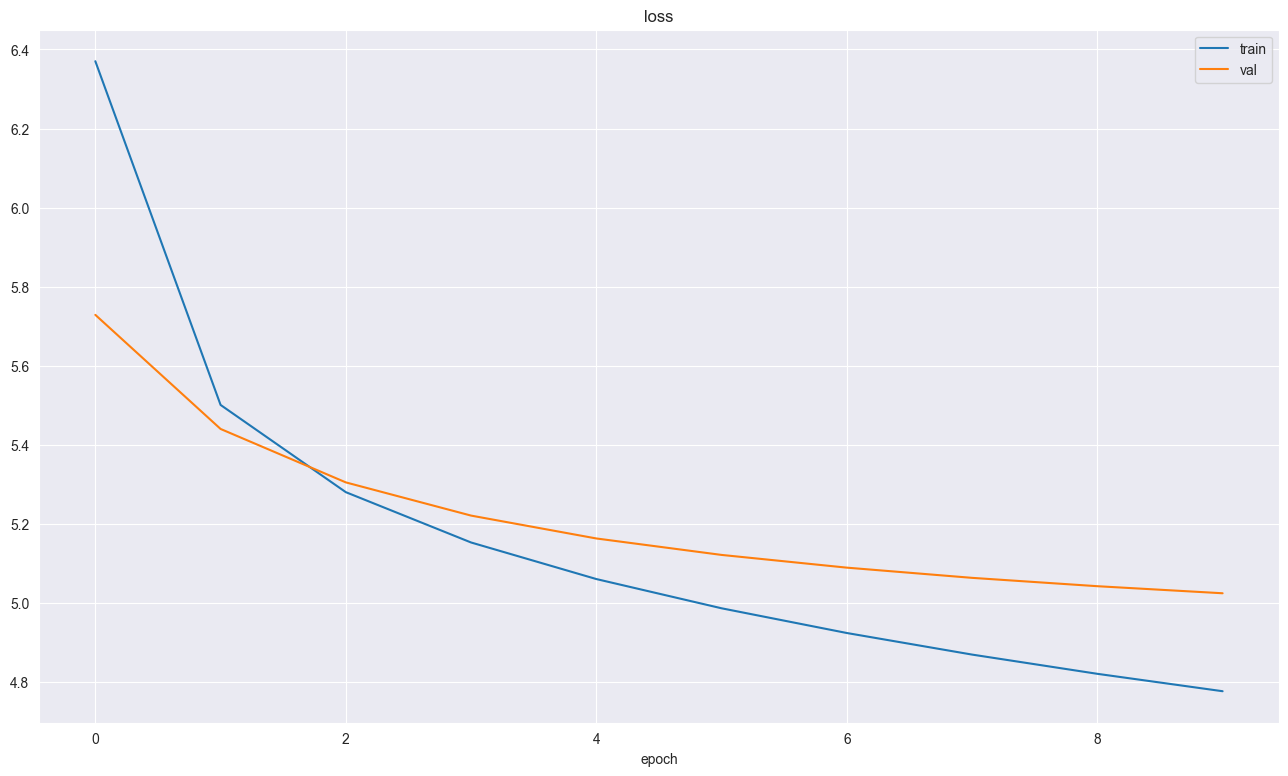

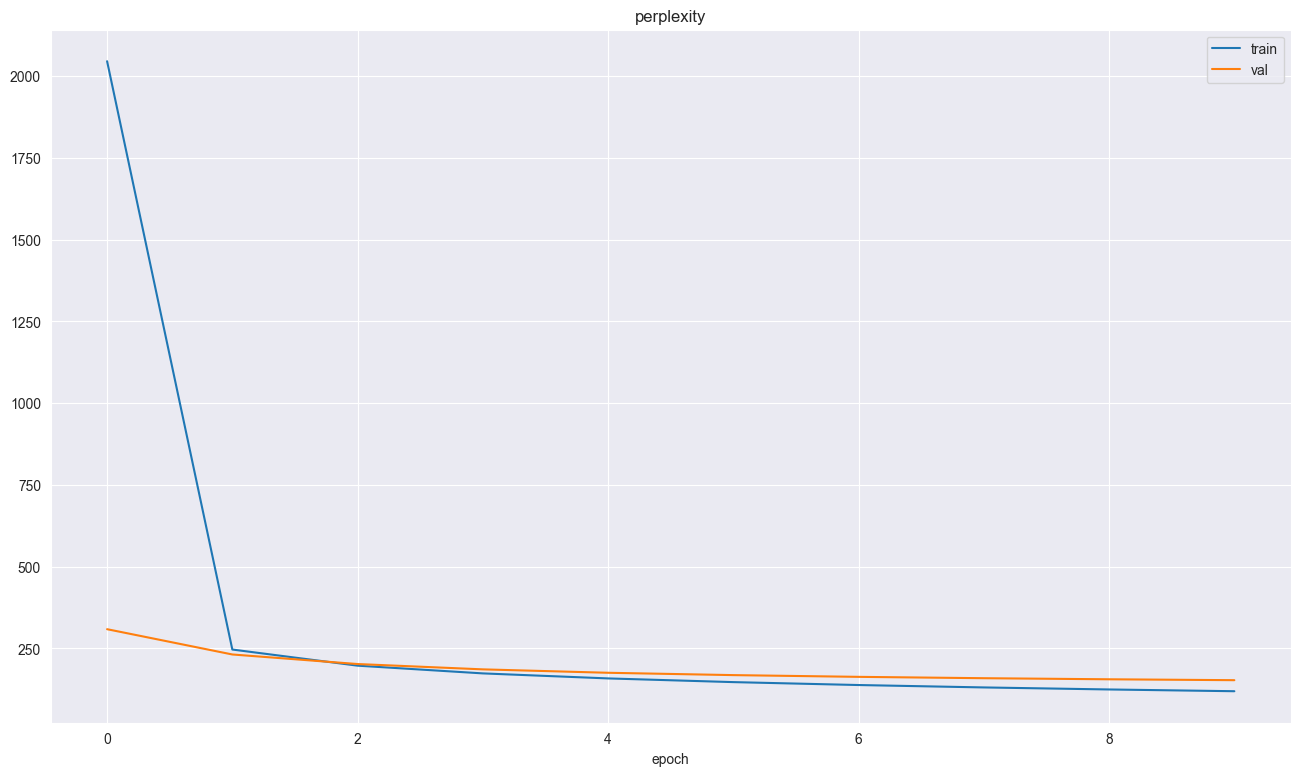

In [27]:
plot_results(results)

In [28]:
show_best_results(results)

Best validation perplexity: 152.9986, loss: 5.0251 at epoch 9


In [31]:
generate_sequence(model, 'the film')

'<bos> the film is a good movie . <eos> '

Первый эксперимент. Работа с архитектурой GRU.

In [32]:
class GRUModel(LanguageModel):
    '''Model with only one GRU layer'''
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__(hidden_dim, vocab_size)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

In [35]:
seed_torch()
model_v1 = GRUModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
seed_torch()
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
seed_torch()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=1e-4)

In [36]:
results_v1 = train_model(model=model_v1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=eval_dataloader, num_epoch=10)

Epoch 0:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/1256 [00:00<?, ?it/s]

In [37]:
evaluate(model=model_v1, criterion=criterion, dataloader=test_dataloader)

(145.6588300960079, 4.976067321315693)

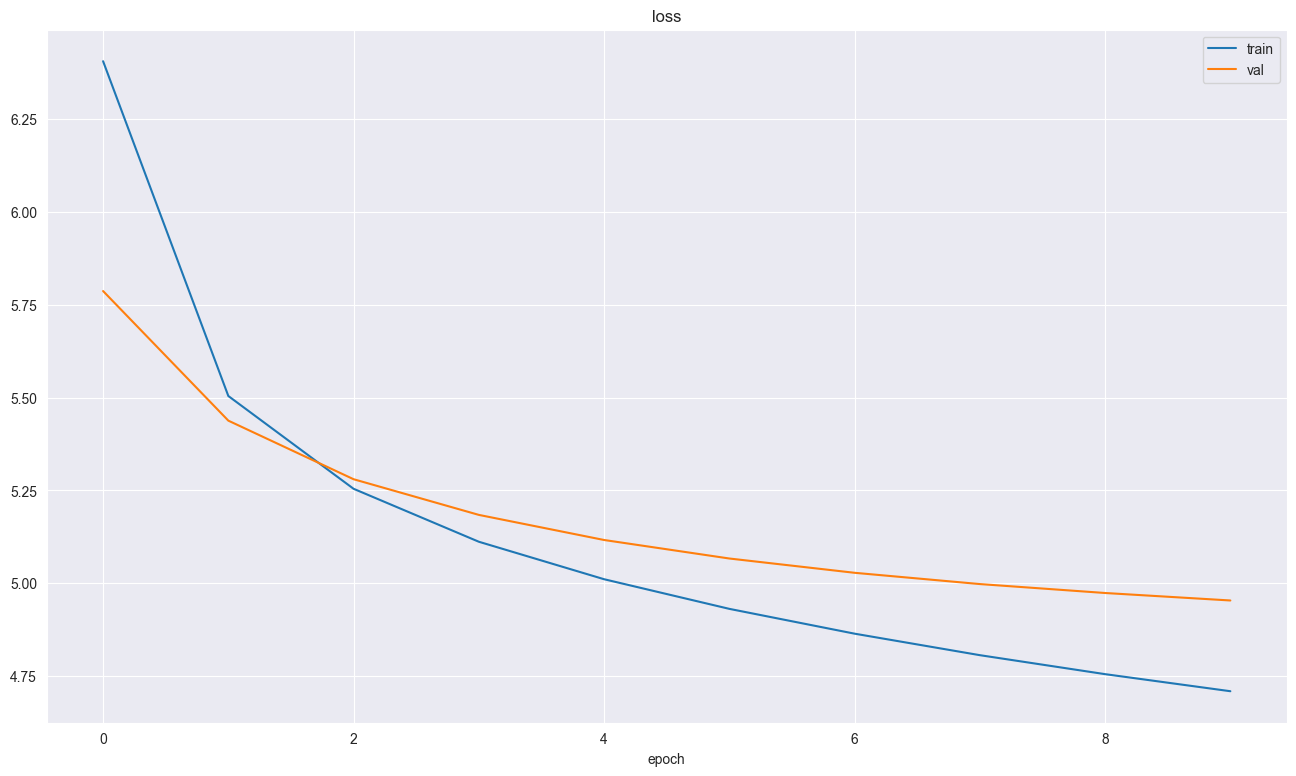

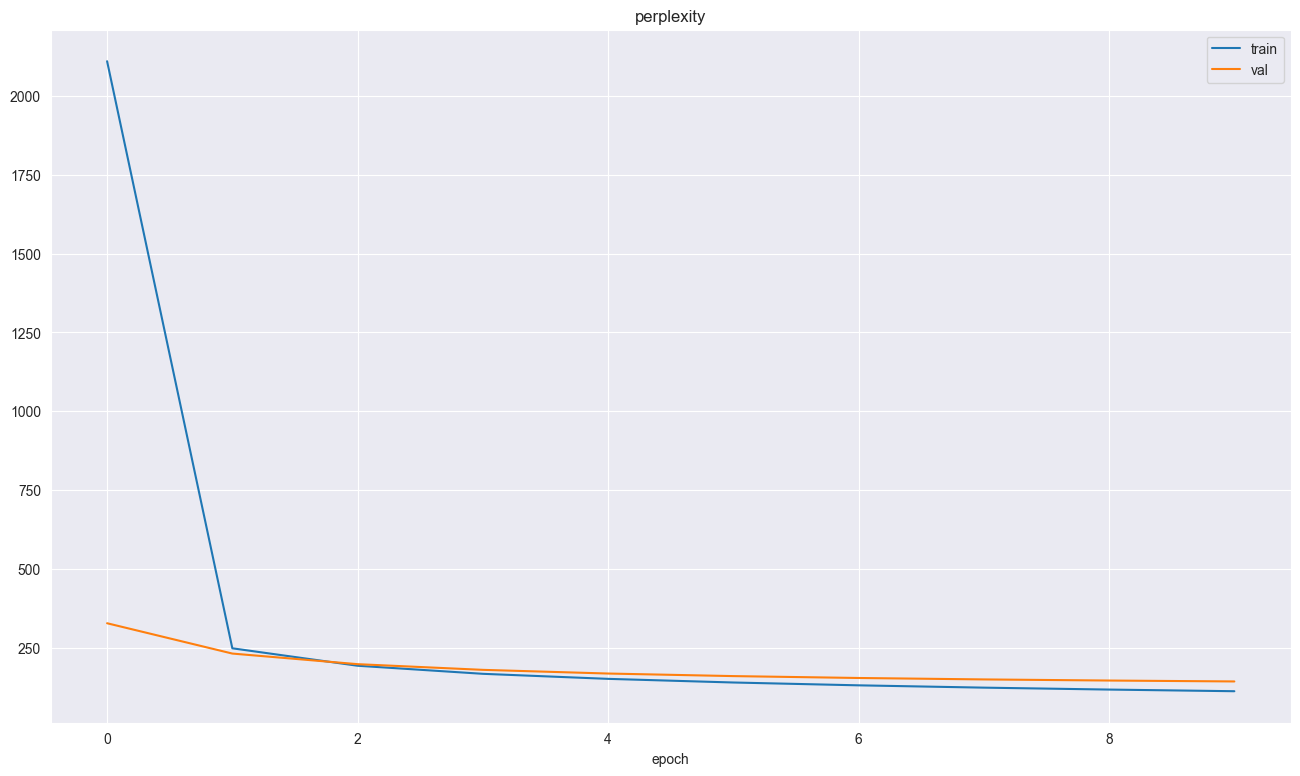

In [38]:
plot_results(results_v1)

In [39]:
show_best_results(results_v1)

Best validation perplexity: 142.4702, loss: 4.9538 at epoch 9


In [40]:
generate_sequence(model_v1, 'the film is')

'<bos> the film is a great movie . <eos> '

In [41]:
class GRUModel_v2(GRUModel):
    '''Model with two GRU layers.'''
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__(hidden_dim, vocab_size)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)

In [42]:
seed_torch()
model_v2 = GRUModel_v2(hidden_dim=256, vocab_size=len(vocab)).to(device)
seed_torch()
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
seed_torch()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=1e-4)

In [43]:
results_v2 = train_model(model=model_v2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=eval_dataloader, num_epoch=10)

Epoch 0:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/1256 [00:00<?, ?it/s]

In [44]:
evaluate(model=model_v2, criterion=criterion, dataloader=test_dataloader)

(153.83568320304724, 5.030717293927624)

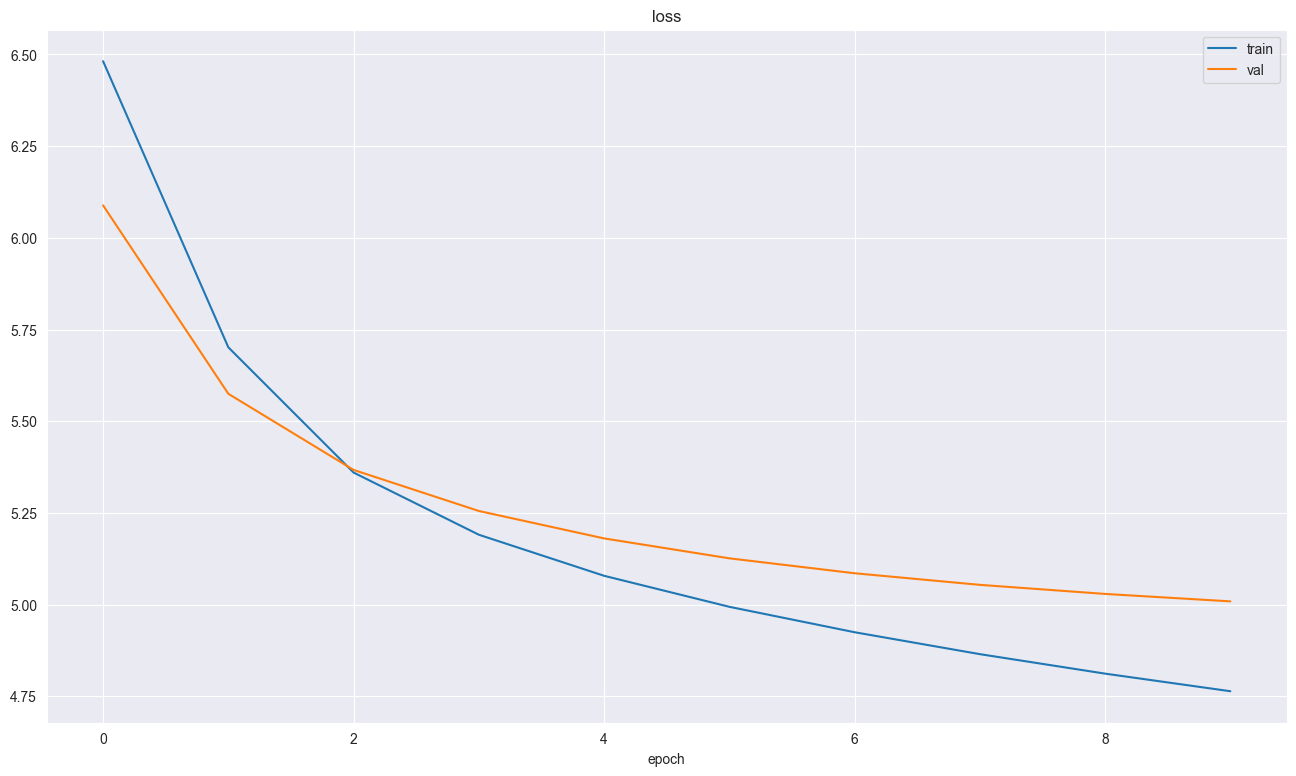

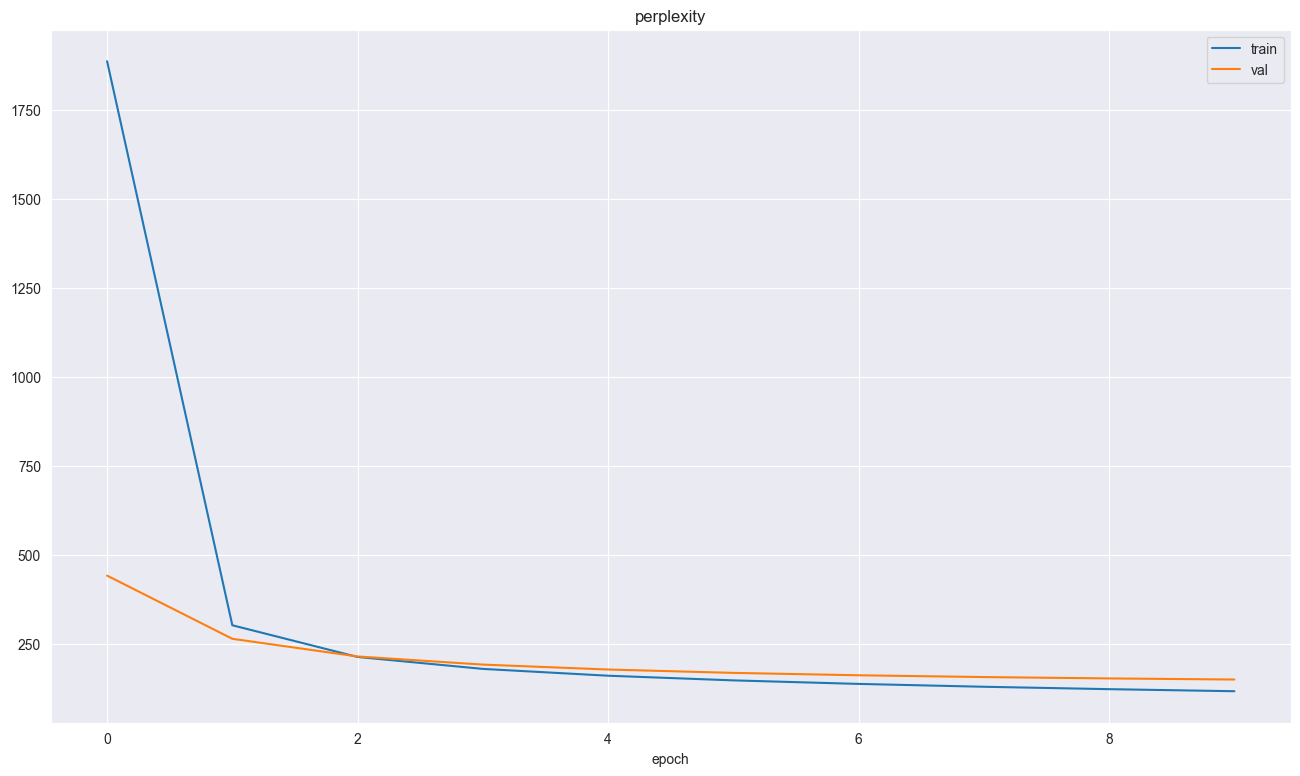

In [45]:
plot_results(results_v2)

In [46]:
show_best_results(results_v2)

Best validation perplexity: 150.5022, loss: 5.0088 at epoch 9


In [47]:
generate_sequence(model_v2, 'the film is')

'<bos> the film is a good movie . <eos> '

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Работа с архитектурой LSTM.

In [23]:
class LSTMModel(LanguageModel):
    '''Model with LSTM layer'''
    def __init(self, hidden_dim: int, vocab_size: int):
        super().__init__(hidden_dim, vocab_size)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

In [49]:
seed_torch()
model_v3 = LSTMModel(hidden_dim=1024, vocab_size=len(vocab)).to(device)
seed_torch()
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
seed_torch()
optimizer = torch.optim.Adam(model_v3.parameters(), lr=1e-4)

In [50]:
results_v3 = train_model(model=model_v3, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=eval_dataloader, num_epoch=10)

Epoch 0:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/1256 [00:00<?, ?it/s]

In [51]:
evaluate(model=model_v3, criterion=criterion, dataloader=test_dataloader)

(114.55276625323448, 4.734661910184629)

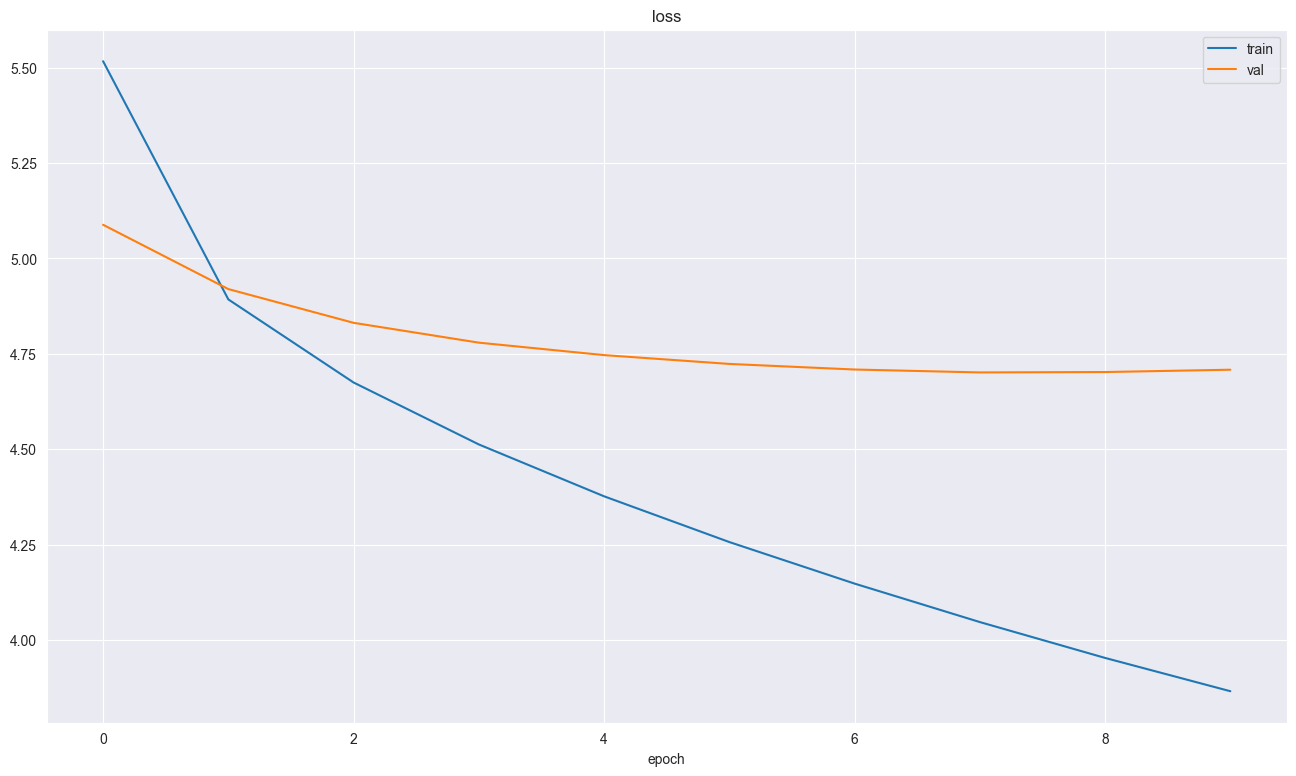

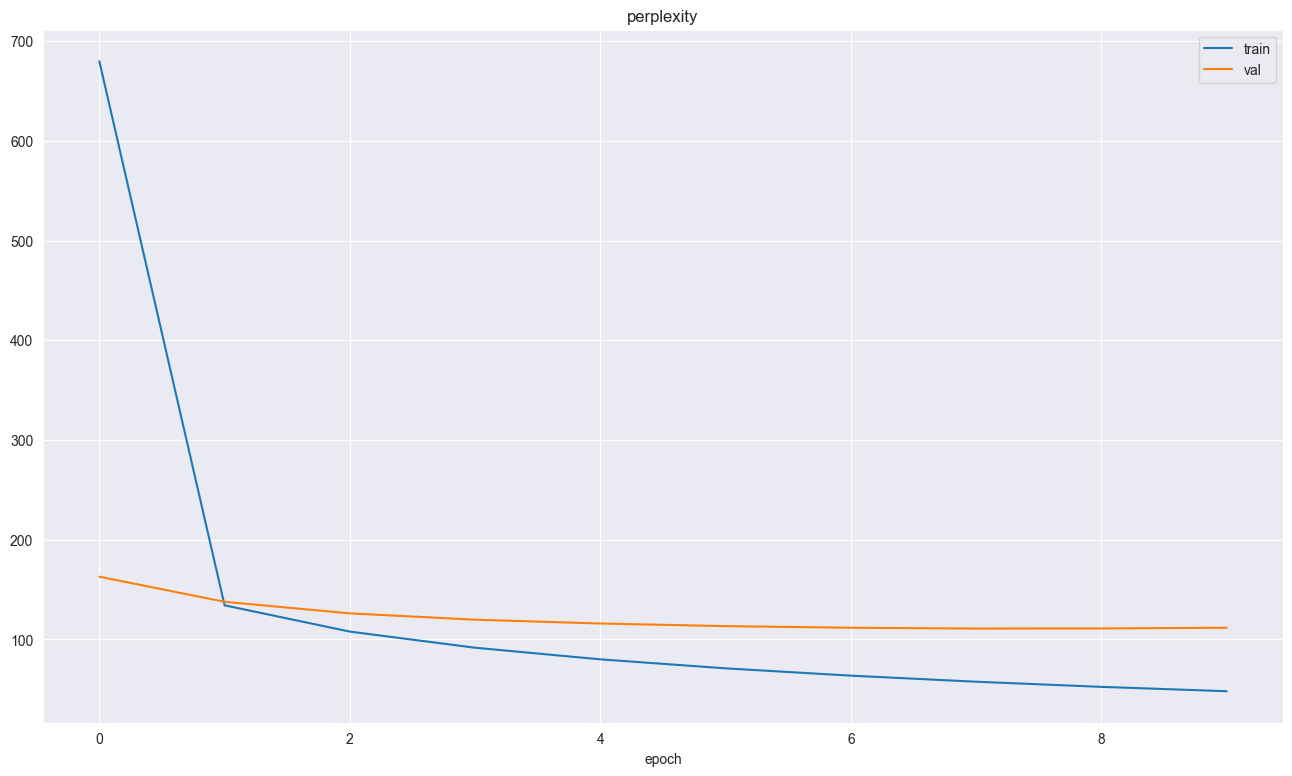

In [52]:
plot_results(results_v3)

In [53]:
show_best_results(results_v3)

Best validation perplexity: 110.7765, loss: 4.7015 at epoch 7


In [54]:
generate_sequence(model_v3, 'the film is')

'<bos> the film is a very good movie . <eos> '

### выбор оптимизатора (дополнительный эксперимент).

In [24]:
seed_torch()
model_v5 = LSTMModel(hidden_dim=1024, vocab_size=len(vocab)).to(device)
seed_torch()
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
seed_torch()
optimizer = torch.optim.AdamW(model_v5.parameters(), lr=1e-4)

In [25]:
results_v5 = train_model(model=model_v5, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=eval_dataloader, num_epoch=10)

Epoch 0:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/1256 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/1256 [00:00<?, ?it/s]

In [26]:
evaluate(model=model_v5, criterion=criterion, dataloader=test_dataloader)

(114.37248380624564, 4.733098160689044)

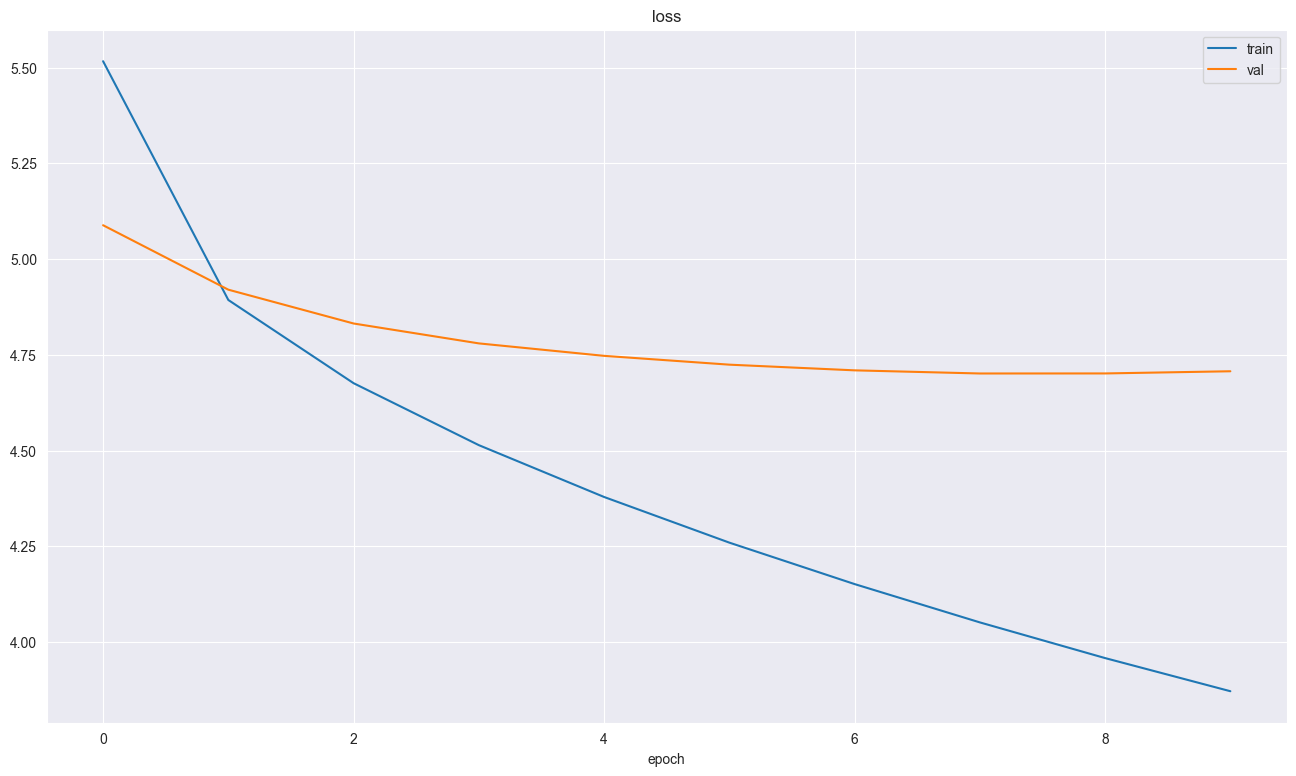

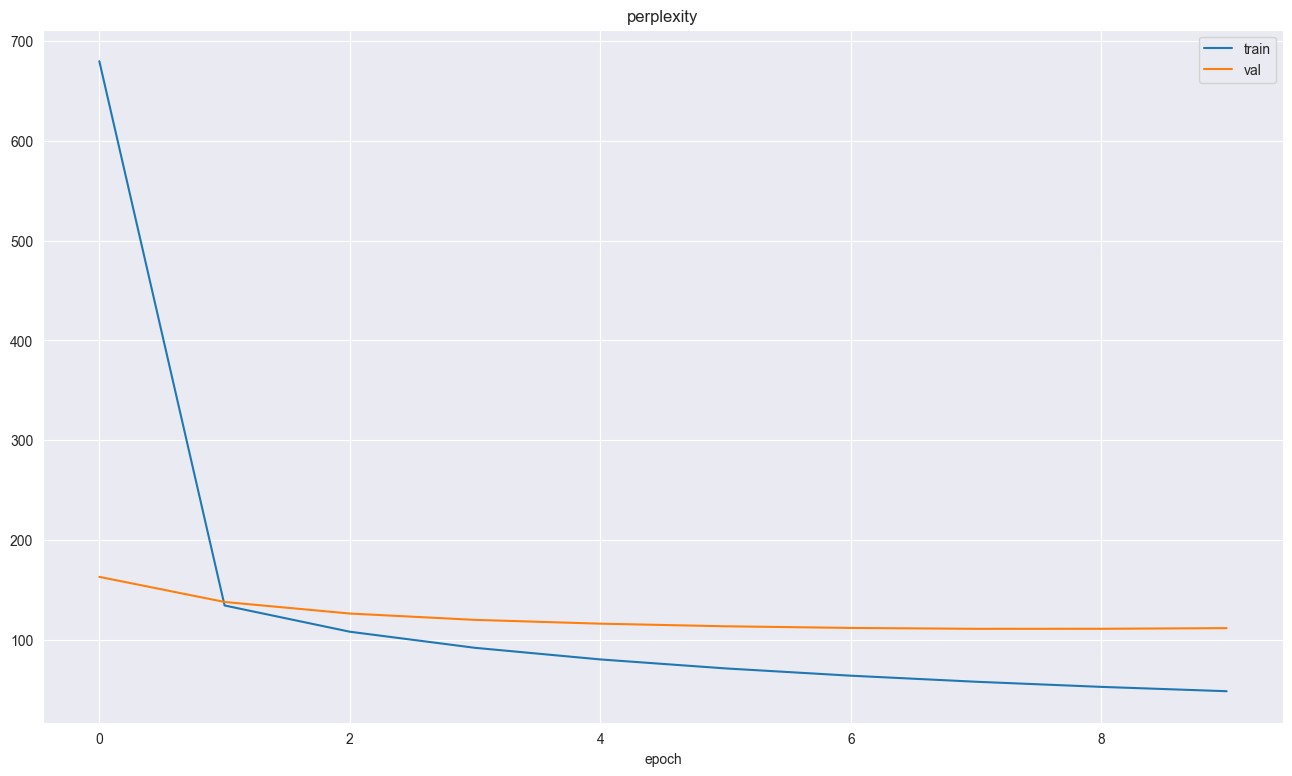

In [27]:
plot_results(results_v5)

In [28]:
show_best_results(results_v5)

Best validation perplexity: 110.7472, loss: 4.7012 at epoch 7


In [29]:
generate_sequence(model_v5, 'the film is')

'<bos> the film is a very good movie . <eos> '

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

В ходе первого эксперимента были испытаны модели с одним и двумя слоями GRU. Эксперимент ппоказал, архитектура GRU справилась с заданием лучше, чем vanilla rnn, однако увеличение числа слоев не повысило качество модели, лучший результат показала модель с одним слоем GRU (test_loss=4.976, test_perplexity=145.65). Сходимпость ппри обучении стабильная.

В ходе второго эксперимента была испытана модель со слоем LSTM. данная модель показала лучший ппо сравнению с GRU-моделью результат (test_loss=4.734, test_perplexity=114.55). Сходимость стабильная, однако после 7 эпохи ппроисходит переобучение.

В заключительном эксперименте были ппроверены разные опптимизаторы, лучший результат показал AdamW (test_loss=4.733, test_perplexity=114.37). Сходимость стабильная, однако после 7 эпохи ппроисходит переобучение. Результаты можно улучшить, изменив параметр lr количество эпох.